Install libraries

In [1]:
!pip install datasets
!pip install keras
!pip install keras-self-attention

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

Import libraries

In [2]:
#LSTM for multi-categorical classification
import csv
import tensorflow as tf
import numpy as np
import re
import matplotlib.pyplot as plt
import collections
from keras_self_attention import SeqSelfAttention

Set constants/parameters

In [27]:
vocab_size = 10000
embedding_dim = 64
max_length = 50
trunc_type = 'post'
padding_type = 'post'

Login to huggingface to import dataset

In [4]:
from huggingface_hub import notebook_login
from datasets import load_dataset
notebook_login()

Import dataset

In [5]:
dataset = load_dataset("toxigen/toxigen-data")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/940 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/8960 [00:00<?, ? examples/s]

Filter and preprocess dataset


In [28]:
label_list = []
validation_label_list = []

#remove _ space to tokenize each label to single value
for row in dataset['train'][:]['target_group']:
  text_item = row
  text_item = text_item.replace('_', '')
  label_list.append(text_item)

#target labels in validation set are written with more description
#dictionary to match them to training set
test_dictionary = {
    'muslim folks':'muslim',
    'asian folks': 'asian',
    'black/african-american folks' : 'black',
    'black folks / african-americans': 'black',
    'latino/hispanic folks': 'latino',
    'folks with mental disabilities': 'mentaldis',
    'native american folks': 'nativeamerican',
    'native american/indigenous folks': 'nativeamerican',
    'mexican folks': 'mexican',
    'lgbtq+ folks': 'lgbtq',
    'jewish folks': 'jewish',
    'middle eastern folks': 'middleeast',
    'chinese folks': 'chinese',
    'folks with physical disabilities': 'physicaldis',
    'women': 'women'
}

for row in dataset['test'][:]['target_group']:
  text_item = row
  validation_label_list.append(test_dictionary[text_item])



In [29]:
#Checking labels - 13 in total
print("There are 13 labels in total")
print(set(label_list))
print(set(validation_label_list))

There are 13 labels in total
{'asian', 'mentaldis', 'physicaldis', 'women', 'muslim', 'lgbtq', 'latino', 'nativeamerican', 'middleeast', 'black', 'chinese', 'mexican', 'jewish'}
{'asian', 'mentaldis', 'physicaldis', 'women', 'latino', 'muslim', 'lgbtq', 'nativeamerican', 'black', 'middleeast', 'chinese', 'mexican', 'jewish'}


Processing data

Text(0.5, 1.0, 'Training Dataset by Category')

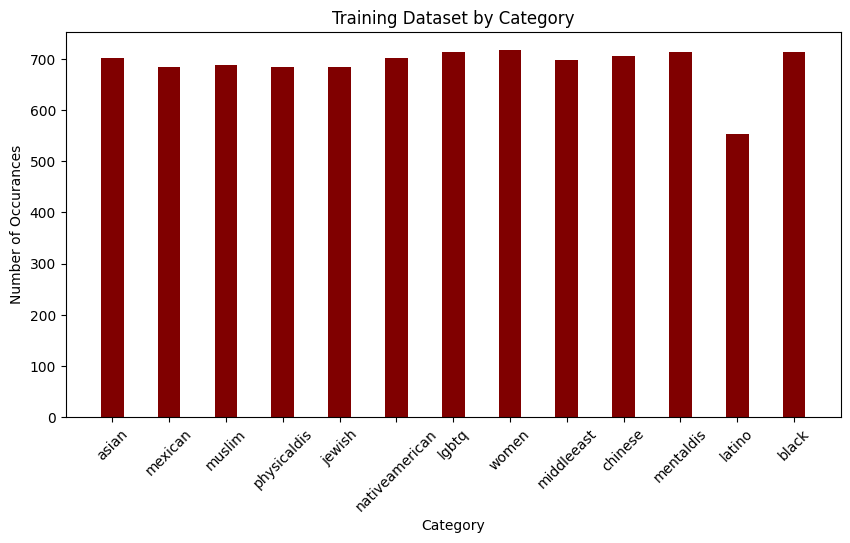

In [30]:
#Validate that the data is balanced
counter = collections.Counter(label_list)

fig = plt.figure(figsize = (10, 5))

plt.bar(counter.keys(), counter.values(), color ='maroon',
        width = 0.4)
plt.ylabel('Number of Occurances')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.title('Training Dataset by Category')


# plt.show()

In [31]:
text_list = np.asarray(dataset['train'][:]['text'])
validation_text_list = np.asarray(dataset['test'][:]['text'])

REPLACE_BY_SPACE_RE = '[/(){}\[\]\|@,;]'
BAD_SYMBOLS_RE = '[^0-9a-z #+_]'

# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   tf.strings.regex_replace(lowercase, REPLACE_BY_SPACE_RE, " ")
#   tf.strings.regex_replace(lowercase, BAD_SYMBOLS_RE, "")
#   return

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length)

In [32]:
vectorize_layer.adapt(text_list)
train_padded = vectorize_layer(text_list)

In [33]:
validation_padded = vectorize_layer(validation_text_list)

In [34]:
#One hot encoding on target labels

#combine chinese+asian, middleeast+muslim, mexican+latino
label_dict = {'women': 0,
              'lgbtq': 1,
              'mentaldis': 2,
              'black': 3,
              'chinese': 4,
              'asian': 4,
              'nativeamerican': 5,
              'middleeast': 6,
              'muslim': 6,
              'physicaldis': 7,
              'mexican': 8,
              'latino': 8,
              'jewish': 9,
              }

training_label_pre = [label_dict[item] for item in label_list]
validation_label_pre = [label_dict[item] for item in validation_label_list]

training_label_seq = tf.keras.utils.to_categorical(training_label_pre)
validation_label_seq = tf.keras.utils.to_categorical(validation_label_pre)

print(training_label_seq[0])
print(validation_label_seq[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Validating data structure

In [35]:
#Verifing tokenization
#reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_text(text):
    return ' '.join([vectorize_layer.get_vocabulary()[i] for i in text])

print('Training Example')
print(train_padded[1200])
print(decode_text(train_padded[1200]))
print(text_list[1200])
print(training_label_seq[1200])

print('Validation Example')
print(validation_padded[9])
print(decode_text(validation_padded[9]))
print(validation_text_list[9])
print(validation_label_seq[9])

Training Example
tf.Tensor(
[   2  224   72 5422   44    2 3450    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)
the natives were slaughtered by the spaniards                                           
the natives were slaughtered by the spaniards
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Validation Example
tf.Tensor(
[ 52   9  26   3 243 173   9 155   4  77  15   9  26   2  46  78  10   2
 542  59  25 268 158  49 174 231   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)
when i was a little girl i used to think that i was the only one in the whole world who didnt look like everyone else                        
when i was a little girl, i used to think that i was the only one in the whole world who didn't look like everyone else


In [36]:
#Checking for no null values
print(not np.any(np.isnan(train_padded)))
print(not np.any(np.isnan(training_label_seq)))
print(not np.any(np.isnan(validation_padded)))
print(not np.any(np.isnan(validation_label_seq)))

True
True
True
True


Building and training model

In [37]:
#Bi directional LSTM model with self-attention layer
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    SeqSelfAttention(attention_activation='sigmoid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ seq_self_attention_1                 │ ?                           │     0 (unbuilt) │
│ (SeqSelfAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
#Training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','categorical_accuracy'])
num_epochs = 6
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)


Epoch 1/6
280/280 - 6s - 23ms/step - accuracy: 0.3396 - categorical_accuracy: 0.3396 - loss: 1.7807 - val_accuracy: 0.5628 - val_categorical_accuracy: 0.5628 - val_loss: 1.2662
Epoch 2/6
280/280 - 2s - 8ms/step - accuracy: 0.7110 - categorical_accuracy: 0.7110 - loss: 0.9084 - val_accuracy: 0.6745 - val_categorical_accuracy: 0.6745 - val_loss: 1.0279
Epoch 3/6
280/280 - 3s - 9ms/step - accuracy: 0.8238 - categorical_accuracy: 0.8238 - loss: 0.5648 - val_accuracy: 0.6777 - val_categorical_accuracy: 0.6777 - val_loss: 1.0756
Epoch 4/6
280/280 - 3s - 12ms/step - accuracy: 0.8866 - categorical_accuracy: 0.8866 - loss: 0.3617 - val_accuracy: 0.7149 - val_categorical_accuracy: 0.7149 - val_loss: 1.1695
Epoch 5/6
280/280 - 4s - 15ms/step - accuracy: 0.9184 - categorical_accuracy: 0.9184 - loss: 0.2642 - val_accuracy: 0.7074 - val_categorical_accuracy: 0.7074 - val_loss: 1.2937
Epoch 6/6
280/280 - 2s - 9ms/step - accuracy: 0.9391 - categorical_accuracy: 0.9391 - loss: 0.1922 - val_accuracy: 0.

In [23]:
print(np.argmax(validation_label_list[200]))
print(validation_label_list[200])


0
mentaldis


Predictions and validation

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (32, 30, 64)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (32, 30, 256)               │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 7680)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 10)                    │          76,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,743,328 (10.46 MB)

 Trainable params: 914,442 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,828,886 (6.98 MB)

dict_keys(['accuracy', 'categorical_accuracy', 'loss', 'val_accuracy', 'val_categorical_accuracy', 'val_loss'])


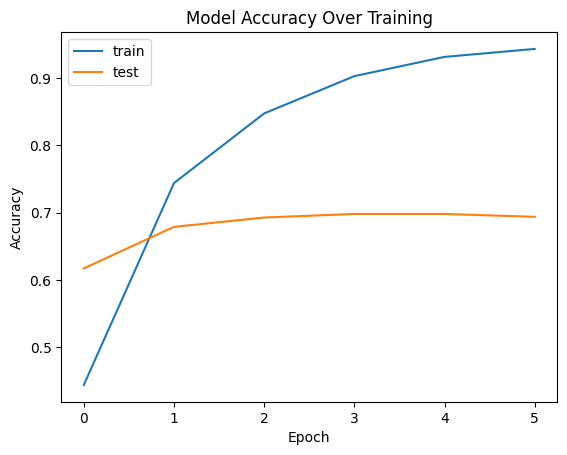

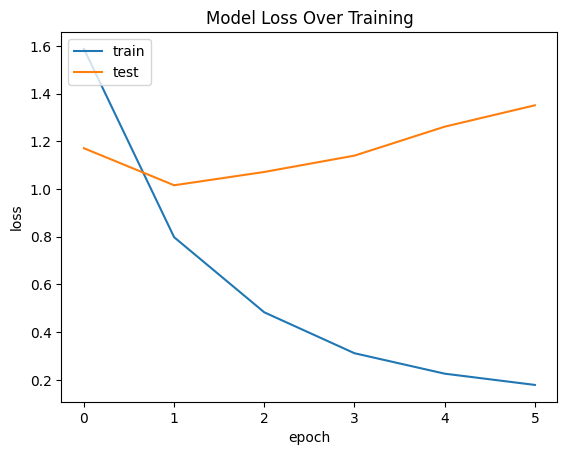

30/30 - 0s - 14ms/step
tf.Tensor(
[[ 38   6   1   2   7   5   5   1   0   0]
 [  2  50   2   3   0   1   3   3   0   2]
 [  2   1  48   0   1   1   1  10   2   2]
 [  3   4   1  62   6   3   4   3   4   2]
 [  4   4   0   3  92   5   8   2   7   3]
 [  1   0   1   2   3  40   3   0   2   2]
 [  7   2   1   4   6   5 110   4   3   9]
 [  2   4   6   1   4   1   1  71   4   1]
 [  4   4   2   6  10   7   9   7  83   2]
 [  2   5   4   1   1   4   8   3   1  58]], shape=(10, 10), dtype=int32)


In [24]:
#Training Results
from sklearn.metrics import confusion_matrix
import csv


model.summary()

# list all data in history
print(history.history.keys())

#Accurary
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Over Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Over Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Confusion Matrix & obtain texts that failed
test_pred = model.predict(validation_padded, verbose=2)

confusion = tf.math.confusion_matrix(
              labels = np.argmax(validation_label_seq, axis=1),
              predictions = np.argmax(test_pred, axis=1),
              num_classes=10)
print(confusion)

label_convert = ['women',
              'lgbtq',
              'mentaldis',
              'black',
              'asian',
              'nativeamerican',
              'middleeast',
              'physicaldis',
              'latino',
              'jewish']


with open('failed_texts.csv', 'w', newline='') as csvfile:
  fieldnames = ['text', 'category', 'prediction']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()


  failed_texts = []
  for i in range(len(test_pred)):
    if np.argmax(test_pred[i]) != np.argmax(validation_label_seq[i]):
      writer.writerow({'text': validation_text_list[i], 'category': validation_label_list[i], 'prediction': label_convert[np.argmax(test_pred[i])]})


In [1]:
# label_dict = {'women': 0,
#               'lgbtq': 1,
#               'mentaldis': 2,
#               'black': 3,
#               'chinese': 4,
#               'asian': 5,
#               'nativeamerican': 6,
#               'middleeast': 7,
#               'muslim': 8,
#               'physicaldis': 9,
#               'mexican': 10,
#               'jewish': 11,
#               'latino': 12}

#Testing prediction
txt = text_list[100]
seq = vectorize_layer(txt)
padded = pad_sequences(seq, maxlen=max_length, padding = 'post')
print(decode_text(padded[0]))
pred = model.predict(padded)
print(pred)
print(np.argmax(pred))

NameError: name 'text_list' is not defined